IMPORT VARIABLES

In [16]:
import torch
import math
import cv2
from tqdm import tqdm
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from scipy import signal,misc
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2,fftshift,fft,ifft2,ifftshift
from empatches import EMPatches
import imgviz  # just for plotting
import numpy as np
from skimage import color, data, restoration

DECLARE GLOBAL VARIABLES

In [17]:
N = 128# Kernel Size
radius = N//4#np.sqrt(N//np.pi) #Radius of the aperture
center = [N//2,N//2]
lam = 0.55 * 10**-6
wave_number = 2*np.pi/lam
W_d = 0 
W_sa = 0
W_coma= 5 * lam
W_astig = 0
W_field = 0
W_distort  = 0 
#Shift of point in test image
side =2
x_shift = 10
y_shift  = 0
#For patching
patch_size = 64
step_size = 32
overlapPercent = 1- (step_size/patch_size)

In [18]:
img = np.array([[1,2,3],
       [4,5,6],
       [7,8,9]])

out = np.where(img<0,0,1)

print(out)

[[1 1 1]
 [1 1 1]
 [1 1 1]]


Expand the components of the complex image

In [19]:
def remove_spikes(img,amp):
    out = img

    out[np.where(img*np.where(amp>0,0,1)>=np.pi)]=0.0
    return out



def expand_complex_image(phase_mask):
    ph_real = np.real(phase_mask)
    ph_imag = np.imag(phase_mask)
    ph_mag =  np.sqrt(ph_imag**2+ph_real**2)
    ph_phase = np.arctan2(ph_imag,ph_real)
        
    return(ph_real,ph_imag,ph_mag,ph_phase)

def get_mag(A):
    ph_mag =  np.sqrt(np.real(A)**2+np.imag(A)**2)
    return ph_mag

FFT

In [20]:
def fft_image(img):
    return(fftshift(fft2(fftshift(img))))

GENERATE APERTURE FUNCTION

In [21]:


def hypergaussian(x,y,radius):
    return(np.exp(-1*((x**2+y**2)/radius**2)**50))

def lcs(img):
    return(img-np.min(img)/(np.max(img)-np.min(img)))

def amplitude_aperture(N,radius,center):
    x = np.linspace(0,N-1,N,dtype = int)
    y = x
    X = x-center[0]
    Y = y-center[1]
    out = np.zeros((N,N))
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            out[i,j] = hypergaussian(x,y,radius)

    return out
def star_field(img_size,step_size):
    img = np.zeros(img_size,float)
    for i in range(0,img.shape[0],step_size):
        for j in range(0,img.shape[1],step_size):
            img[i,j]= 1.0
            img[i-1,j-1]=1.0
            img[i+1,j+1]=1.0
            img[i+1,j-1]=1.0
            img[i-1,j+1]=1.0
            img[i,j+1]=1.0
            img[i,j-1]=1.0
            img[i+1,j]=1.0
            img[i-1,j]=1.0

    return img
            
def generate_norm_factor(shape,patch_size,step_size):
    img = np.ones(shape,dtype = float)
    overlapPercent = 1-(step_size/patch_size)
    emp = EMPatches()
    img_patches, indices = emp.extract_patches(img, patchsize=patch_size, overlap=overlapPercent)
    window = np.zeros(img.shape,float)
    sum = np.zeros(img.shape,dtype=float)
    for id,patch in enumerate(img_patches):
        ind = indices[id]
        window[ind[0]:ind[1],ind[2]:ind[3]]= 1
        temp = img*window
        sum = sum + temp
        window[ind[0]:ind[1],ind[2]:ind[3]]= 0
    for j in range(img.shape[0]):
        for i in range(img.shape[1]):
            sum[i,j] = 1/sum[i,j]
    return(sum)
   
amp = amplitude_aperture(N,radius,center)
#amp = amp/np.max(amp)
img = star_field((256,256),16)

SHOW APERTURE

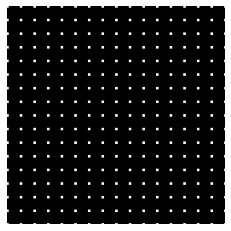

In [22]:
plt.figure(0)
plt.imshow(img,cmap='gray');
plt.axis("off")
plt.show()


GENERATE PHASE FUNCTION

In [23]:
#Seidel Aberration Function 

def seidel (p0,q0,x,y):
    beta = np.arctan2(q0,p0)
    h2 = np.sqrt(p0**2 + q0**2)
    #rotation of grid
    xr = x*np.cos(beta)+y*np.sin(beta)
    yr = -x*np.sin(beta) + y*np.cos(beta)

    #Seidel Aberration function

    rho2 = xr**2 + yr**2

    W = W_d*rho2 + W_sa*rho2**2 + W_coma*h2*rho2*xr + W_astig*h2**2*xr**2 + W_field*h2**2*rho2 + W_distort*h2**3*xr
    return W
# def aberr_function(x,y,h,type='coma'):
#     r = np.sqrt(x**2+y**2)
#     #s1,s2,s3,s4,s5 = 0.011432,0.010331,-0.028367,0.062155,-0.059211
#     s1,s2,s3,s4,s5 = 0,-100*0.050482796*10**-5,0,0,0
    
#     if type=='spherical':
#         W = W_sa
#     elif type =='coma':
#         W = W_coma
#     elif type == 'astigmatism':
#         W  = W_astig
#     elif type == 'field curvature':
#         W  = W_field
#     elif type =='distortion':
#         W = W_dist
#     elif type =='all':
#         W = W_sa+W_coma+W_astig+W_field+W_dist
#     else :
#         print("Give a valid aberrration  type")

#     return (W)



In [24]:
def phase_aperture(N,center,radius,phase_constant,p0,q0):
    x = np.linspace(0,N-1,N,dtype = int)
    y = x
    X = x-center[0]
    Y = y-center[1]
    X = X/radius
    Y = Y/radius
    out = np.zeros((N,N),dtype=complex)
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            out[i,j] = np.exp(-1*phase_constant*seidel(p0,q0,x,y)*1j)

    return out
phase_mask = phase_aperture(N,center,radius,wave_number,1,0)
pupil = amp*(phase_mask)
A,B,C,D = expand_complex_image(pupil)


SHOW PHASE FUNCTION


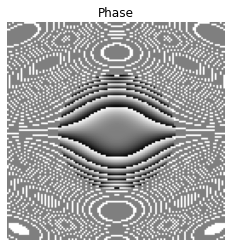

0.9999999999999991 -0.9999999999999991


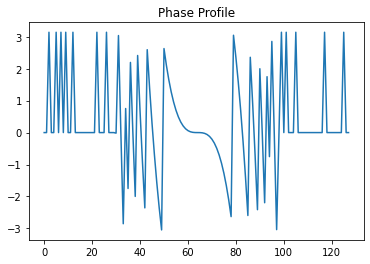

[ 0.00000000e+00  0.00000000e+00  3.14159265e+00 -0.00000000e+00
  0.00000000e+00  3.14159265e+00  0.00000000e+00  3.14159265e+00
  0.00000000e+00  3.14159265e+00  0.00000000e+00 -0.00000000e+00
  3.14159265e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.14159265e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.14159265e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -1.68737887e-02  3.03824070e+00
 -4.77736048e-15 -2.85416300e+00  7.53184567e-01 -1.75008033e+00
  2.19666049e+00  2.12839834e-02 -1.99877697e+00  2.41391052e+00
  6.87223393e-01 -9.01405460e-01 -2.35772847e+00  2.59568724e+00
  1.38671863e+00  2.92798583e-01 -6.91825335e-01 -1.57290555e+00
 -2.35619449e+00 -3.04744458e+00  2.63077705e+00  2.10634737e+00
  1.65669925e+00  1.27608027e+00  9.58737992e-01  6.98919996e-01
  4.90873852e-01  3.28847131e-01  2.07087406e-01  1.19842249e-01
  6.13592315e-02  2.58859

In [25]:
plt.figure(1)
plt.title(r"Phase")
plt.imshow(D,cmap='gray');
plt.axis("off")
plt.show()
print(np.max(B),np.min(B))
#Line plot
arr = D[:,N//2]
plt.figure(2)
plt.plot(arr)
plt.title(r"Phase Profile")
plt.axis("on")
plt.show()

print(arr)

584056.0495949694


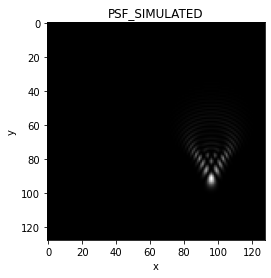

In [26]:
q = np.roll(get_mag(fft_image(pupil))**2,(32,32),axis=(0,1))
print(np.max(q))
plt.figure(4)
plt.title(r"PSF_SIMULATED")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('on')
plt.imshow(q, cmap='gray')

764.2355982254225


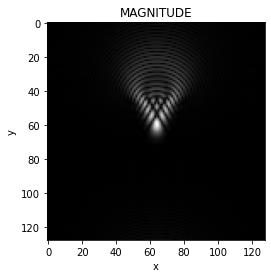

In [27]:
l = get_mag(fft_image(pupil))
print(np.max(l))
plt.figure(5)
plt.title(r"MAGNITUDE")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('on')
plt.imshow(l, cmap='gray')

UPLOAD TEST IMAGE 


(512, 512)


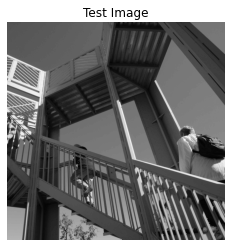

In [28]:
# get image either RGB or Grayscale
#img = cv2.imread('test.jpeg')
img = misc.ascent()
#img = np.pad(img,step_size)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_s = star_field(img.shape,64)
img_s = np.pad(img_s,step_size)
img_R = np.sqrt((img.shape[0]//2)**2 +(img.shape[1]//2)**2)
#img = np.zeros((128,128),dtype=float)
#img[img.shape[0]//2-side//2-x_shift:img.shape[0]//2+side//2-x_shift,
     #img.shape[1]//2-side//2-y_shift:img.shape[1]//2+side//2-y_shift] = 1
# plot the test image
plt.figure(4)
plt.title(r"Test Image")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('off')
plt.imshow(img,cmap='gray')
print(img.shape)


INTERPOLATION FUNCTION

In [29]:
def tri(patch_size):
    X = np.array(range(0,patch_size))
    Y = np.array(range(0,patch_size))
    X = (X-patch_size//2) 
    Y = (Y-patch_size//2)
    out = np.zeros((patch_size,patch_size),dtype=float)
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            out[i,j]=((1-np.abs(2*x/(patch_size)))*(1-np.abs(2*y/(patch_size))))
    return out

out = tri(4)
#window = np.zeros((16,16))
#window[0:3,0:3] = tri(3)

print(out)


[[0.   0.   0.   0.  ]
 [0.   0.25 0.5  0.25]
 [0.   0.5  1.   0.5 ]
 [0.   0.25 0.5  0.25]]


IMAGE PROCESSING

In [30]:
# #------------------------------#
# # ---------PATCHING -----------#
# #------------------------------#
# patch_size = 256
# overlapPercent = 0
# emp = EMPatches()
# img_patches, indices = emp.extract_patches(img, patchsize=patch_size, overlap=overlapPercent)
# X=[]
# Y=[]
# for ind in indices:
#     X.append((ind[0] + ind[1])//2)
#     Y.append((ind[2]+ind[3])//2)
    
# P_new = (np.array(X)-img.shape[0]//2)/img_R
# Q_new = (np.array(Y)-img.shape[1]//2)/img_R
# # H_new = np.sqrt(P_new**2+Q_new**2)
# # H_new = H_new/np.max(H_new)
# # print(H_new)
# psf_arr=[]
# for q0 in Q_new:
#     for p0 in P_new:
#         G = amp*(phase_aperture(N,center,radius,wave_number,p0,q0))
#         p_norm = get_mag(fft_image(G))**2
#         p_norm = p_norm/np.sum(p_norm)
#         psf_arr.append([p_norm,p0,q0])

In [31]:

# # displaying 1st 10 image patches
# plt.figure()
# plt.imshow(psf_arr[1][0],cmap='gray')
# #print(np.max(psf_arr[0][1]))
# #print( [(psf[1],psf[2]) for psf in psf_arr])

PIECEWISE CONVOLUTION

In [32]:

# result=[]
# X= len(img_patches)
# window = np.zeros(img.shape)
# canvas = window
# sum = np.zeros(img.shape,dtype=float)
# for psf,p,q in psf_arr:
#     u = int(p*img_R)+(img.shape[0]//2)
#     v = int(p*img_R)+(img.shape[1]//2)
#     win = patch_size//2
#     window[u-win:u+win,v-win:v+win]= 1
#     #patch= img[ind[0]:ind[1],ind[2]:ind[3]]
#     temp = cv2.filter2D(img*window,-1,psf)
#     #temp = img*window
#     #temp = signal.convolve2d(img*window,psf_arr[id],mode='same')
#     #print(np.max(temp))
#     #result.append(temp)
#     sum += temp
# #result = np.array(result)
# print(np.max(sum))
# plt.figure()
# plt.imshow(psf_arr,cmap='gray')

MERGE PATCHES

In [33]:
#merged_img = emp.merge_patches(result, indices)
# display
# plt.figure()
# plt.imshow(sum,cmap='gray')

In [34]:
#------------------------------#
# ---------PATCHING -----------#
#------------------------------#
emp = EMPatches()
norm_factor = generate_norm_factor(img.shape,patch_size,step_size)
norm_patches,indcs = emp.extract_patches(norm_factor, patchsize=patch_size, overlap=overlapPercent)
img_patches, indices = emp.extract_patches(img, patchsize=patch_size, overlap=overlapPercent)
imgs_patches,indices1 = emp.extract_patches(img_s, patchsize=patch_size, overlap=overlapPercent)


CALCULATE PSFS

In [35]:


psf_arr = []
for ind in tqdm(indices1):
    X = (ind[0] + ind[1])/2
    Y = (ind[2]+ind[3])/2
    p0 = (X-img.shape[0]/2)/img_R
    q0 = (Y-img.shape[1]/2)/img_R
    G = amp*(phase_aperture(N,center,radius,wave_number,p0,q0))
    p_norm = get_mag(fft_image(G))**2
    p_norm = p_norm/np.sum(p_norm)
    psf_arr.append(p_norm)
    #print(p0,q0)



100%|██████████| 289/289 [00:59<00:00,  4.88it/s]


255.83519106128594


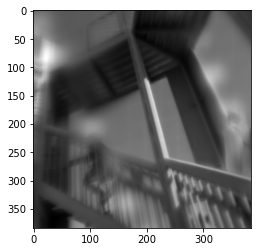

In [36]:


window = np.zeros(img.shape,float)
sum = np.zeros(img.shape,dtype=float)
for id,patch in enumerate(img_patches):
    
    ind = indices[id]
    window[ind[0]:ind[1],ind[2]:ind[3]]= tri(patch_size)
    temp = cv2.filter2D((window*img),-1,np.flip(psf_arr[id],-1),cv2.BORDER_CONSTANT)
    #temp1 =cv2.filter2D(window*norm_factor,-1,psf_arr[id],cv2.BORDER_CONSTANT)
    #temp = window*norm_factor
    sum = sum + temp
    #sum1 = sum1+temp1
    window[ind[0]:ind[1],ind[2]:ind[3]]= 0
sum= sum[patch_size:sum.shape[0]-patch_size,patch_size:sum.shape[1]-patch_size]
print(np.max(sum))
plt.figure()
plt.imshow(sum,cmap='gray')
#print(sum)

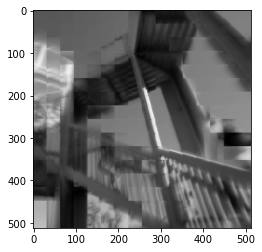

In [37]:
result =[]


for id,patch in enumerate(img_patches):
    ind = indices[id]
    temp = cv2.filter2D(patch,-1,np.flip(psf_arr[id],-1),cv2.BORDER_CONSTANT)
    temp = temp
    result.append(temp)
    
result =  np.array(result)
merged_img = emp.merge_patches(result, indices)

plt.figure()
plt.imshow(merged_img,cmap='gray')

PSF MAP FOR THE IAMGE



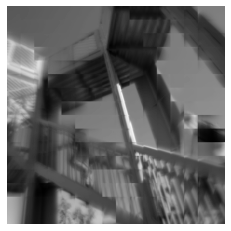

In [38]:
result =[]

for id,patch in enumerate(img_patches):
    ind = indices[id]
    temp = cv2.filter2D(patch,-1,psf_arr[id],cv2.BORDER_CONSTANT)
    #temp = norm_patches[id]
    result.append(temp)
    
result =  np.array(result)
merged_img = emp.merge_patches(result, indices)

plt.figure()
plt.axis('off')
plt.imshow(merged_img,'gray')

DECONVOLUTION

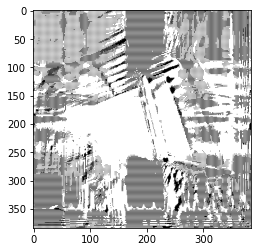

In [39]:
deconv_img = restoration.wiener(sum, psf_arr[0],0.00000001)
plt.figure()
plt.imshow(deconv_img,'gray')

In [40]:
def wiener_filter(img, kernel, K = 10):
    dummy = np.copy(img)
    kernel = np.pad(kernel, [(0, dummy.shape[0] - kernel.shape[0]), (0, dummy.shape[1] - kernel.shape[1])], 'constant')
    # Fourier Transform
    dummy = fft2(dummy)
    kernel = fft2(kernel)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return np.uint8(dummy)


In [1]:
out_patches, indices_out = emp.extract_patches(sum, patchsize=patch_size, overlap=overlapPercent)
deconv_out = np.zeros(sum.shape,dtype=float)
window = np.zeros(sum.shape,float)
for id,patch in enumerate(out_patches):
    ind = indices_out[id]
    window[ind[0]:ind[1],ind[2]:ind[3]]= tri(patch_size)
    psf = psf_arr[id]
    deconv_img = wiener_filter((window*sum),psf,1)
    deconv_out = deconv_img + deconv_out
    window[ind[0]:ind[1],ind[2]:ind[3]]= 0
deconv_out= deconv_out[patch_size:deconv_out.shape[0]-patch_size,patch_size:deconv_out.shape[1]-patch_size]
plt.figure()
plt.axis('off')
plt.imshow(deconv_out,'gray')

NameError: name 'emp' is not defined

In [2]:
deconv_img =   wiener_filter(sum,psf[0],10)
plt.figure()
plt.imshow(deconv_out,'gray')

NameError: name 'wiener_filter' is not defined